In [1]:
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [3]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')

# Scaling the range of the image to [-1, 1]
# Because we are using tanh as the activation function in the last layer of the generator
# and tanh restricts the weights in the range [-1, 1]
X_train = (X_train - 127.5) / 127.5

X_train.shape

(60000, 28, 28, 1)

In [5]:
generator = Sequential([
        Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Reshape((7,7,128)),
        UpSampling2D(),
        Convolution2D(64, 5, 5, border_mode='same', activation=LeakyReLU(0.2)),
        BatchNormalization(),
        UpSampling2D(),
        Convolution2D(1, 5, 5, border_mode='same', activation='tanh')
    ])

/Users/huangjunbin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same", activation=<keras.lay...)`
/Users/huangjunbin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (5, 5), padding="same", activation="tanh")`


In [6]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 64)        0         
__________

In [7]:
discriminator = Sequential([
        Convolution2D(64, 5, 5, subsample=(2,2), input_shape=(28,28,1), border_mode='same', activation=LeakyReLU(0.2)),
        Dropout(0.3),
        Convolution2D(128, 5, 5, subsample=(2,2), border_mode='same', activation=LeakyReLU(0.2)),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])

/Users/huangjunbin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same", strides=(2, 2), activation=<keras.lay..., input_shape=(28, 28, 1...)`
  from ipykernel import kernelapp as app
/Users/huangjunbin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), padding="same", strides=(2, 2), activation=<keras.lay...)`


In [8]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6273      
Total params: 212,865.0
Trainable params: 212,865.0
Non-trainable params: 0.0
________________________________________________________________

In [9]:
generator.compile(loss='binary_crossentropy', optimizer=Adam())

In [10]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

In [11]:
discriminator.trainable = False
ganInput = Input(shape=(100,))
# getting the output of the generator
# and then feeding it to the discriminator
# new model = D(G(input))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(input=ganInput, output=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))   # I have tuned the learning rate here, it's different from the original one

/Users/huangjunbin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`


In [12]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146.0
Trainable params: 1,065,474.0
Non-trainable params: 12,672.0
_________________________________________________________________


In [13]:
def train(epoch=10, batch_size=128):                            # I have tuned the batch_size from 128 to 256
    batch_count = X_train.shape[0] // batch_size
    
    for i in range(epoch):
        for j in tqdm(range(batch_count)):
            # Input for the generator
            noise_input = np.random.rand(batch_size, 100)
            
            # getting random images from X_train of size=batch_size 
            # these are the real images that will be fed to the discriminator
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
            # these are the predicted images from the generator
            predictions = generator.predict(noise_input, batch_size=batch_size)
            
            # the discriminator takes in the real images and the generated images
            X = np.concatenate([predictions, image_batch])
            
            # labels for the discriminator
            y_discriminator = [0]*batch_size + [1]*batch_size
            
            # Let's train the discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_discriminator)
            
            # Let's train the generator
            noise_input = np.random.rand(batch_size, 100)
            y_generator = [1]*batch_size
            discriminator.trainable = False
            gan.train_on_batch(noise_input, y_generator)

In [14]:
train(1, 128)

100%|██████████| 468/468 [24:37<00:00,  3.02s/it]


In [15]:
generator.save_weights('gen_1_scaled_images.h5')
discriminator.save_weights('dis_1_scaled_images.h5')

In [13]:
def plot_output():
    try_input = np.random.rand(100, 100)
    preds = generator.predict(try_input)

    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()

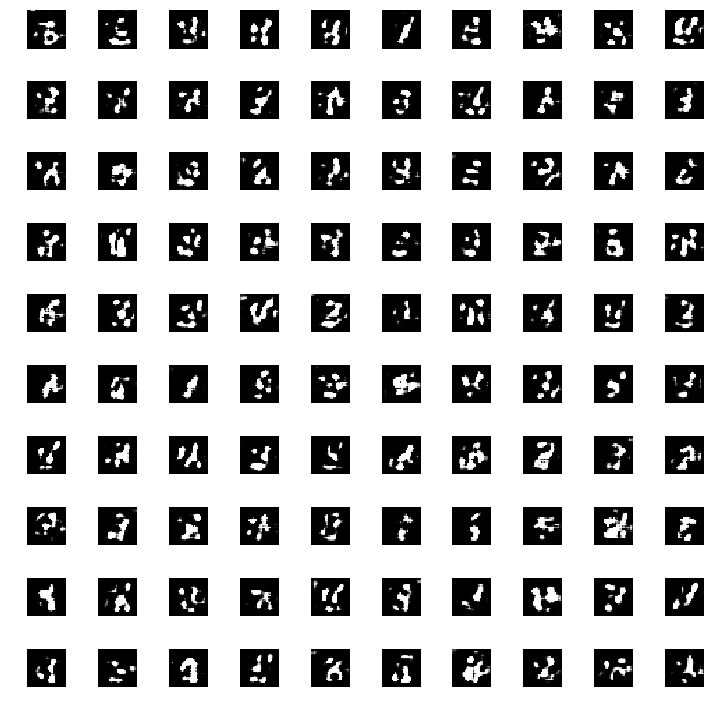

In [17]:
plot_output()   # the output after the first epoch

In [21]:
generator.load_weights('gen_1_scaled_images.h5')
discriminator.load_weights('dis_1_scaled_images.h5')

In [19]:
train(9, 128)

100%|██████████| 468/468 [24:06<00:00,  3.11s/it]


In [20]:
generator.save_weights('gen_10_scaled_images.h5')
discriminator.save_weights('dis_10_scaled_images.h5')

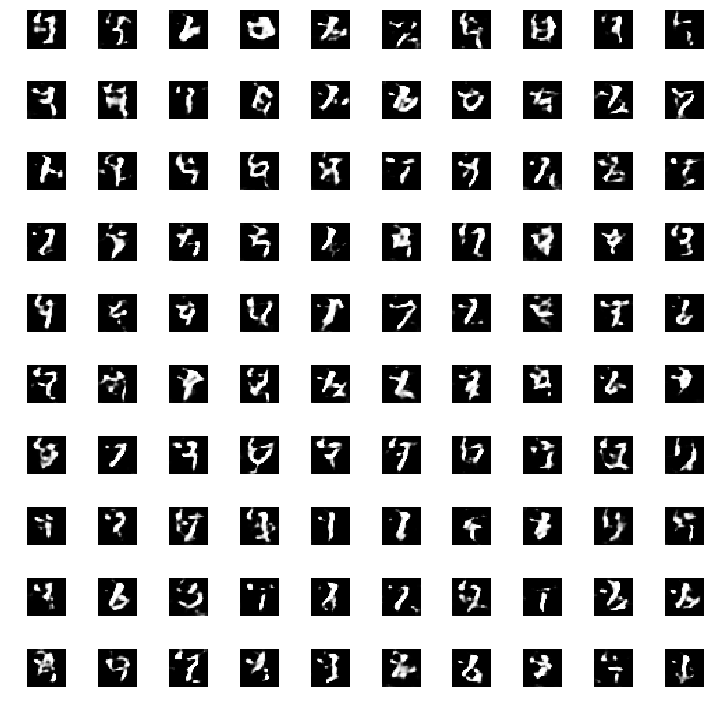

In [22]:
plot_output()   # the output after 10 epochs

In [14]:
generator.load_weights('gen_10_scaled_images.h5')
discriminator.load_weights('dis_10_scaled_images.h5')

In [15]:
train(10, 128) # the output after 20 epochs

100%|██████████| 468/468 [26:24<00:00,  3.24s/it]


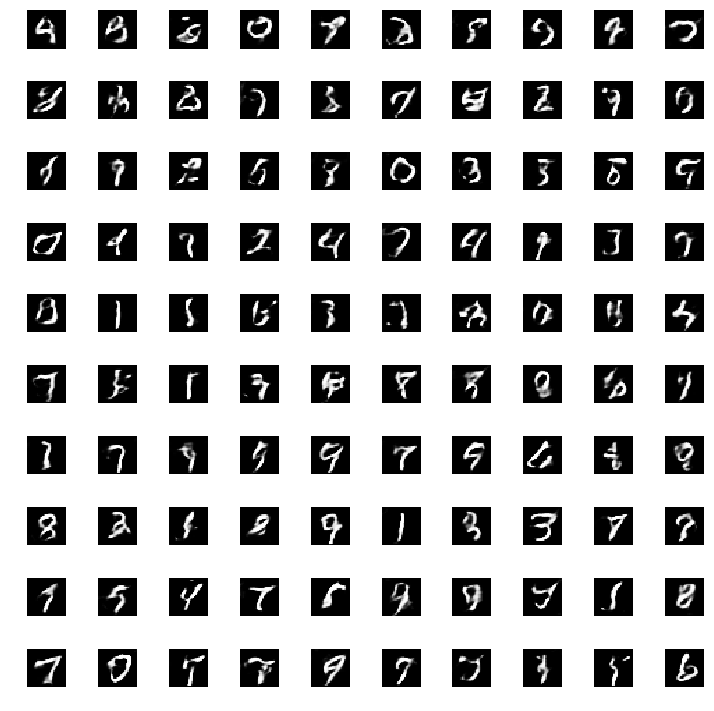

In [20]:
plot_output()

In [23]:
generator.save_weights('gen_20_scaled_images.h5')
discriminator.save_weights('dis_20_scaled_images.h5')

In [24]:
generator.load_weights('gen_20_scaled_images.h5')
discriminator.load_weights('dis_20_scaled_images.h5')

In [25]:
train(20, 128)

100%|██████████| 468/468 [24:14<00:00,  3.07s/it]


In [26]:
generator.save_weights('gen_40_scaled_images.h5')
discriminator.save_weights('dis_40_scaled_images.h5')

In [28]:
generator.load_weights('gen_40_scaled_images.h5')
discriminator.load_weights('dis_40_scaled_images.h5')

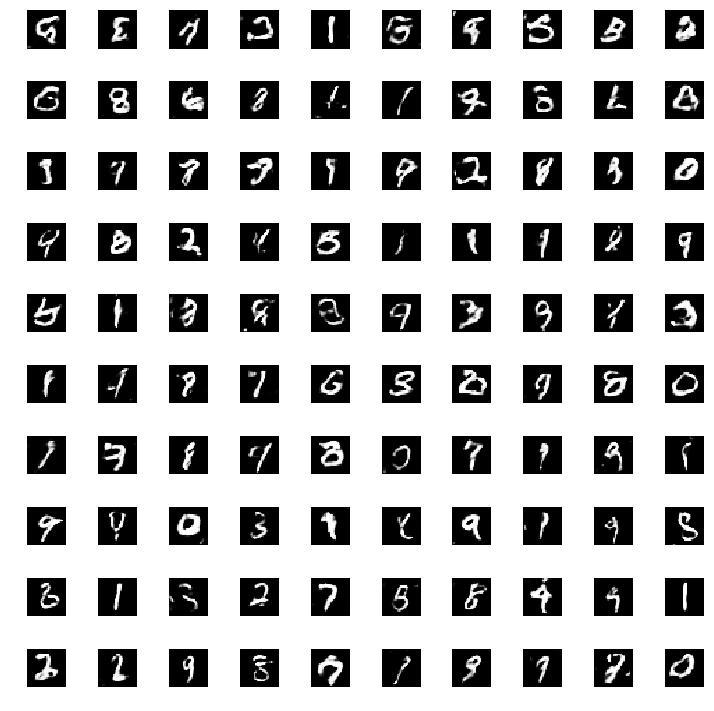

In [29]:
plot_output()

In [30]:
train(20, 128)

100%|██████████| 468/468 [24:45<00:00,  3.23s/it]


In [31]:
generator.save_weights('gen_60_scaled_images.h5')
discriminator.save_weights('dis_60_scaled_images.h5')

In [14]:
generator.load_weights('gen_60_scaled_images.h5')
discriminator.load_weights('dis_60_scaled_images.h5')

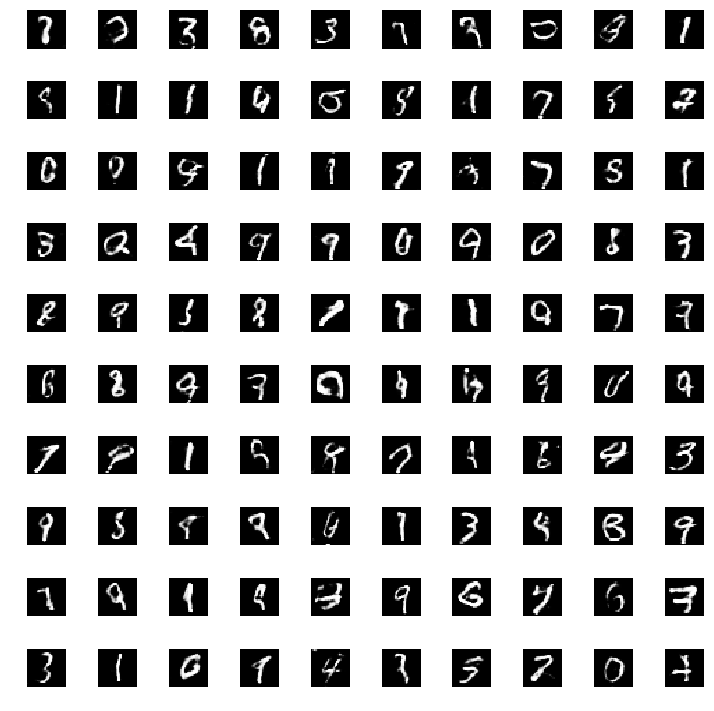

In [33]:
plot_output()

We can note that with the increase of epoch, the figure is getting more clear. What is more, we can clearly note that the figures of 1, 7 and 9 take more and more portions of the output. According to the notes on the web, it is because of the figure showing like one, seven and nine are more easy to be discriminated as a "right" input by the discriminator.


Then we can now adjust the train function to a new one which can auomatically plot the output.

In [21]:
import pylab            # Need this pylab package to show the image after several epoches, 
                        # or the image would not show

def plot_output_small():
    try_input = np.random.rand(100, 100)
    preds = generator.predict(try_input)

    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()
    pylab.show()            # add this commend after the plt.imshow(), make the image show during the running
                                # the alternative method is to use "plt.show()"
    
def train(epoch=10, batch_size=128, show_round = 1):
    batch_count = X_train.shape[0] // batch_size
    
    for i in range(epoch):
        for j in tqdm(range(batch_count)):
            # Input for the generator
            noise_input = np.random.rand(batch_size, 100)
            
            # getting random images from X_train of size=batch_size 
            # these are the real images that will be fed to the discriminator
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
            # these are the predicted images from the generator
            predictions = generator.predict(noise_input, batch_size=batch_size)
            
            # the discriminator takes in the real images and the generated images
            X = np.concatenate([predictions, image_batch])
            
            # labels for the discriminator
            y_discriminator = [0]*batch_size + [1]*batch_size
            
            # Let's train the discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_discriminator)
            
            # Let's train the generator
            noise_input = np.random.rand(batch_size, 100)
            y_generator = [1]*batch_size
            discriminator.trainable = False
            gan.train_on_batch(noise_input, y_generator)
        if 0 == (i%show_round):
            print  "this is the output after ", i+41, "epoches:"
            plot_output_small()